<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Linear Regression</center></h2>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# First of all..
Let's finish previous seminar super fast!

# Now, Linear regression

## Car price

Load [train](http://bit.ly/1gIQs6C) and [test set](http://bit.ly/IYPHrK) about car price

In [3]:
df_train = pd.read_csv('http://bit.ly/1gIQs6C')
df_test = pd.read_csv('http://bit.ly/IYPHrK')

In [4]:
df_train.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


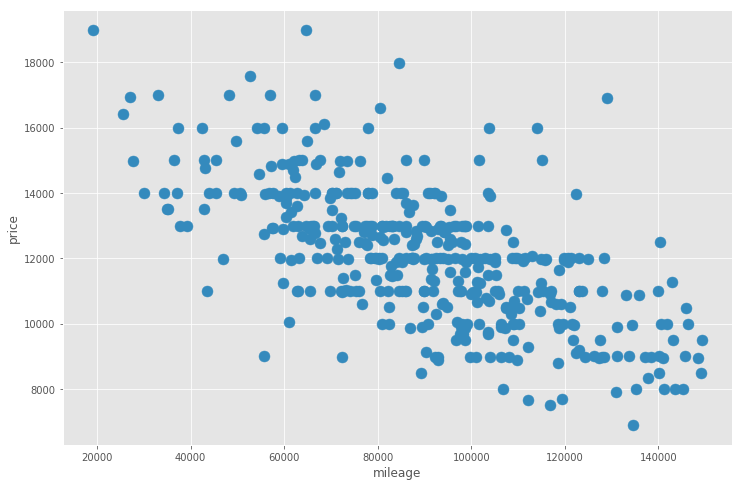

In [5]:
df_train.plot(x='mileage', y='price', kind='scatter', s=120)

Looks line there is linear dependence between mileage and price

In [6]:
X_train = df_train.mileage.values.reshape(-1, 1)
y_train = df_train.price.values

In [7]:
from sklearn.linear_model import LinearRegression

Обучим модель

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
print 'Model:\nprice = %.2f + (%.2f)*mileage' % (model.intercept_, model.coef_[0])

Model:
price = 16762.02 + (-0.05)*mileage


In [10]:
model.intercept_

16762.024910878838

In [11]:
model.coef_

array([-0.05213421])

Plot your model line

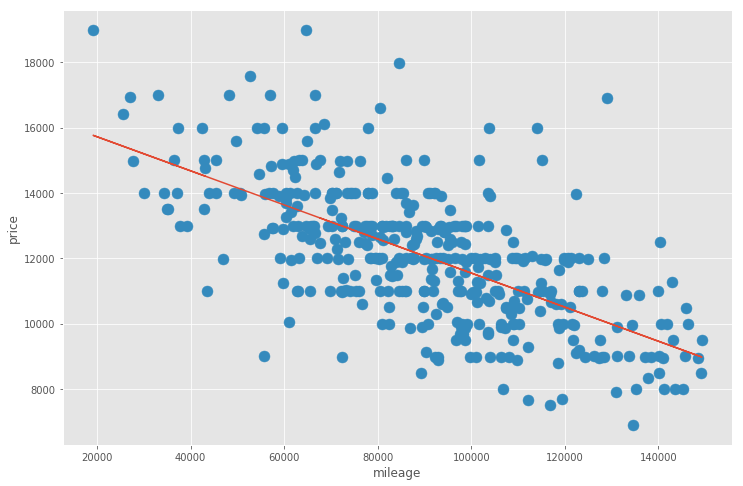

In [12]:
df_train.plot(x='mileage', y='price', kind='scatter', s=120)

y_hat = model.predict(X_train)

plt.plot(X_train, y_hat)

## Your Code Here

### Basic quality measures

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

* $\frac{1}{N} \sum_n |\hat{y}_{n}-y_n|$ - mean absolute error
* $\frac{1}{N} \sum_n (\hat{y}_{n}-y_n)^2$ - mean squared error

In [14]:
y_hat = model.predict(X_train)

In [15]:
print('MAE %.2f' % mean_absolute_error(y_train, y_hat))
print('MSE %.2f' % mean_squared_error(y_train, y_hat))

MAE 1182.21
MSE 2412292.55


Other measure is $R^2$:

* $TSS = \sum_n (y_n-\bar{y})^2$ - total sum of squares
* $RSS = \sum_n (y_n-\hat{y}_n)^2$ - residual sum of squares
* $ESS = \sum_n (\hat{y}_n-\bar{y})^2$ - explained sum of squares

$$TSS = ESS + RSS$$

$R^2=1-\frac{RSS}{TSS}$


## Feature scaling

Feature scaling improves GD performance, but replaces interpretability

Build a pipeline with Standart scaling and train a model

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', StandardScaler()),
                  ('regressor', LinearRegression())])
model.fit(X_train, y_train)

/usr/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [17]:
print('Model :\nprice = %.2f + (%.2f)*mileage`' % (model.steps[1][1].intercept_, 
                                                   model.steps[1][1].coef_[0]))

Model :
price = 12084.24 + (-1351.67)*mileage`


## Gradient descent

In [18]:
# Просто для удобства
X_train = (X_train - X_train.mean())/X_train.std()

In [19]:
# adding a column of "1" into matrix
X_model = np.c_[np.ones(X_train.shape), X_train]
X_model.shape

(417, 2)

In [20]:
X_model[:10]

array([[ 1.        , -0.84965517],
       [ 1.        , -0.61665239],
       [ 1.        , -0.3630531 ],
       [ 1.        , -0.14000144],
       [ 1.        , -0.39028369],
       [ 1.        ,  0.279257  ],
       [ 1.        ,  1.4048907 ],
       [ 1.        ,  1.13894894],
       [ 1.        , -0.62533069],
       [ 1.        , -1.50720052]])

In [21]:
from mpl_toolkits import mplot3d

Text(0,0.5,u'$\\beta_1$')

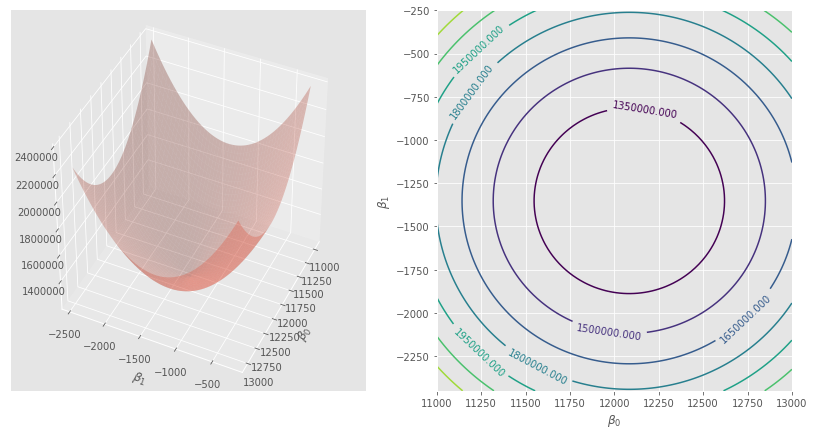

In [22]:
beta0 = np.linspace(11000 , 13000, 100)
beta1 = np.linspace(-2450, -250, 100)

B0, B1= np.meshgrid(beta0, beta1)

B_all = np.c_[B0.reshape(-1,1), B1.reshape(-1,1)].T

L = X_model.dot(B_all) - y_train.reshape(-1,1)
L = L ** 2
L = L.mean(axis=0)/2
L = L.reshape(B0.shape)


fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(40, 25)
ax.plot_surface(B0, B1, L, alpha=0.3,)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')

ax = fig.add_subplot(1, 2, 2)
contour = ax.contour(B0, B1, L)
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')

General steps:

* Set random initial $\beta$
* Until converged:
    * Calculate residuals and error
    * Calculate gradients
    * Update coefs

In [23]:
def gradient_descent(X, y, iters, alpha):
    
    costs = []
    betas = []
    
    n = y.shape[0] 
    Beta = np.random.rand(X.shape[1])
    for i in xrange(iters):
        y_hat = X.dot(Beta)
        
        # Calculate residuals and error
        resid = y_hat - y
        cost = (resid**2).mean()
        costs.append(cost)
        
        # Calculate gradient
        grad = X.T.dot(resid)

        # Update weights
        Beta = Beta - (alpha/n)*grad
        betas.append(Beta)
                    
    return Beta, costs, betas

In [24]:
Beta, costs, betas = gradient_descent(X_model, y_train, 100, 0.05)

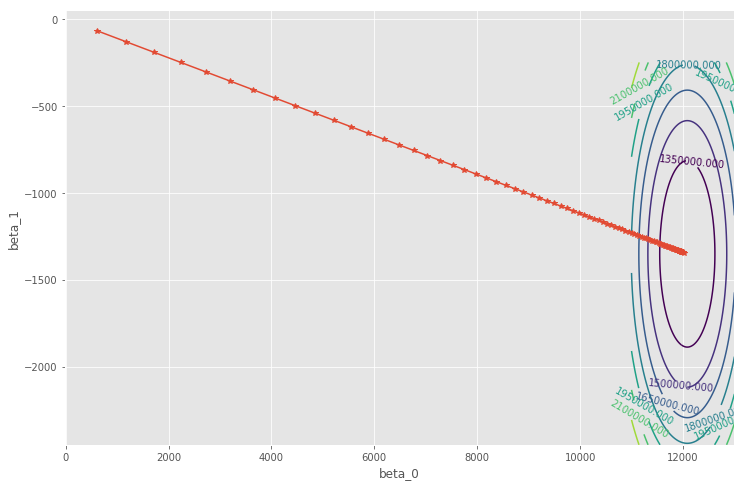

In [25]:
beta0 = np.linspace(11000 , 13000, 100)
beta1 = np.linspace(-2450, -250, 100)

B0, B1= np.meshgrid(beta0, beta1)

B_all = np.c_[B0.reshape(-1,1), B1.reshape(-1,1)].T

L = X_model.dot(B_all) - y_train.reshape(-1,1)
L = L ** 2
L = L.mean(axis=0)/2
L = L.reshape(B0.shape)

fig, ax = plt.subplots(1,1)
contour = ax.contour(B0, B1, L)
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

betas = np.array(betas)
ax.plot(betas[:,0], betas[:,1], marker='*')


## Outliers

Squared error is very sensitive to outliers...

In [26]:
df_train = pd.read_csv('http://bit.ly/1gIQs6C')

In [27]:
X_train = df_train.mileage.values.reshape(-1, 1)
y_train = df_train.price.values

n = y_train.shape[0]

In [28]:
## Add random outliers

In [29]:
for i in range(10):
    X_train = np.r_[X_train, [[250000+np.random.rand()*10000]]]
    y_train = np.r_[y_train, 16000+np.random.randn()*1000]

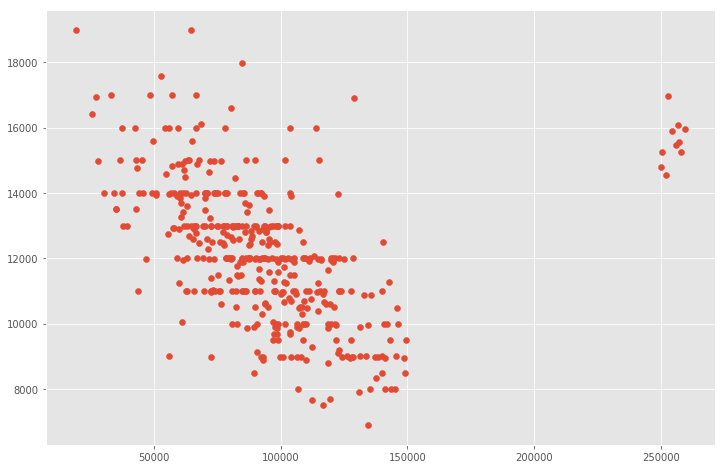

In [30]:
plt.scatter(X_train, y_train)

In [31]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train[:n], y_train[:n])

model_ouliers = LinearRegression(fit_intercept=True)
model_ouliers.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

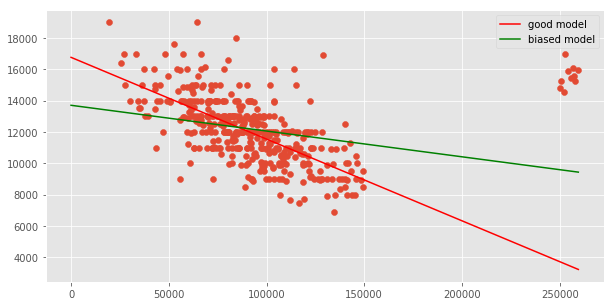

In [32]:
x = np.linspace(0, max(X_train), 100).reshape(-1, 1)
y_hat = model.predict(x)
y_hat_outliers = model_ouliers.predict(x)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_train, y_train)

ax.plot(x, y_hat, c='red', label='good model')
ax.plot(x, y_hat_outliers, c='green', label='biased model')
plt.legend()

### RANSAC регрессия

Idea of RANdom SAmple Consensus (RANSAC) is based in learing a sequence of models on random objects. Since outliers are rare, it is not likely that many of them would be sampled

Determine:
* Loss function
* Threshold $\theta$ 
* Stopping rule

Steps
1. Sample random K object and train model M
2. Compare residuals with $\theta$ and assign objects to outliers or inner objects
3. Train model on inner objects
4. Repear 1-3 until stopped

In [33]:
from sklearn.linear_model import RANSACRegressor

In [34]:
model_ransac = RANSACRegressor(LinearRegression())
model_ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

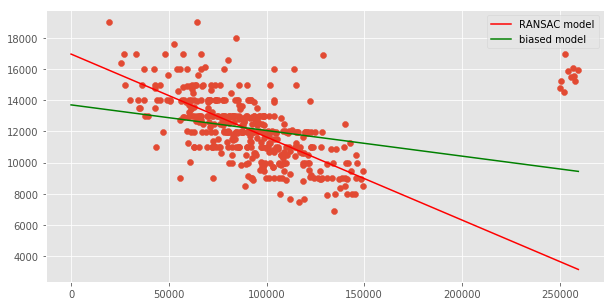

In [35]:
x = np.linspace(0, max(X_train), 100).reshape(-1, 1)
y_hat = model_ransac.predict(x)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_train, y_train)

ax.plot(x, y_hat, c='red', label='RANSAC model')
ax.plot(x, y_hat_outliers, c='green', label='biased model')
plt.legend()

### Robust Estimators

Instead of $$ L(\beta_0,\beta_1,\dots) = \frac{1}{2N}\sum^{N}_{n=1}(\hat{y}_n - y_n)^2$$
Minimize weighted criterion $$ L_w(\beta_0,\beta_1,\dots) = \frac{1}{2N}\sum^{N}_{n=1}\rho_i(\hat{y}_n - y_n)^2,$$
where $\rho_i$ is sample $x_i$ weight based on its residuals

Need to install `statsmodels` with `pip`

In [36]:
!pip install statsmodels

    100% |████████████████████████████████| 6.3MB 23kB/s ta 0:00:01    63% |████████████████████▎           | 4.0MB 45kB/s eta 0:00:51
    100% |████████████████████████████████| 26.3MB 26kB/s eta 0:00:010% |                                | 40kB 15kB/s eta 0:27:37    20% |██████▌                         | 5.4MB 56kB/s eta 0:06:10    28% |█████████▏                      | 7.5MB 38kB/s eta 0:08:08    36% |███████████▌                    | 9.5MB 34kB/s eta 0:08:02    47% |███████████████▎                | 12.5MB 24kB/s eta 0:09:27    48% |███████████████▌                | 12.7MB 28kB/s eta 0:07:58    55% |█████████████████▉              | 14.7MB 34kB/s eta 0:05:32    64% |████████████████████▋           | 16.9MB 30kB/s eta 0:05:05    86% |███████████████████████████▊    | 22.7MB 29kB/s eta 0:02:01
    100% |████████████████████████████████| 235kB 86kB/s ta 0:00:01
Exception:
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main

In [37]:
import statsmodels.api as sm

ImportError: No module named statsmodels.api

In [ ]:
c = 4.685
support = np.linspace(-3*c, 3*c, 1000)
tukey = sm.robust.norms.TukeyBiweight(c=c)
plt.plot(support, tukey(support))
plt.ylim(.1, -4.1)

In [ ]:
model_robust = sm.RLM(y_train, sm.add_constant(X_train), M=sm.robust.norms.TukeyBiweight())
model_robust = model_robust.fit()

In [ ]:
model_robust.summary()

In [ ]:
x = np.linspace(0, max(X_train), 100).reshape(-1, 1)
y_hat = model_robust.predict(sm.add_constant(x))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_train, y_train)

ax.plot(x, y_hat, c='red', label='Robust model')
ax.plot(x, y_hat_outliers, c='green', label='biased model')
plt.legend()